# [**Classification de documents textuels à l'aide de k-means**](https://nbviewer.org/github/Franck-PepperLabs/pepper_data-science_practising/blob/main/Sklearn/examples/text/plot_document_clustering.ipynb)<br/>([*Clustering text documents using k-means*](https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html))

Il s'agit d'un exemple montrant comment l'API scikit-learn peut être utilisée pour regrouper des documents par sujets à l'aide d'une [**approche de sac de mots** (wkpd)](https://en.wikipedia.org/wiki/Bag-of-words_model).

Deux algorithmes sont en démonstration : [**`KMeans`**](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) et sa variante plus évolutive, [**`MiniBatchKMeans`**](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html). De plus, l'analyse sémantique latente est utilisée pour réduire la dimensionnalité et découvrir des modèles latents dans les données.

Cet exemple utilise deux vectoriseurs de texte différents : un [**`TfidfVectorizer`**](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) et un [**`HashingVectorizer`**](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.HashingVectorizer.html). Voir l'exemple de bloc-notes [**Comparaison de FeatureHasher et DictVectorizer**](https://scikit-learn.org/stable/auto_examples/text/plot_hashing_vs_dict_vectorizer.html) pour plus d'informations sur les vectoriseurs et une comparaison de leurs temps de traitement.

Pour l'analyse de documents via une approche d'apprentissage supervisé, voir l'exemple de script [**Classification de documents texte à l'aide de caractéristiques creuses**](https://scikit-learn.org/stable/auto_examples/text/plot_document_classification_20newsgroups.html).

In [1]:
# Author: Peter Prettenhofer <peter.prettenhofer@gmail.com>
#         Lars Buitinck
#         Olivier Grisel <olivier.grisel@ensta.org>
#         Arturo Amor <david-arturo.amor-quiroz@inria.fr>
# License: BSD 3 clause

# Chargement de données textuelles

Nous chargeons les données du [**jeu de données textuelles The 20 newsgroups** (7.2.2)](https://scikit-learn.org/stable/datasets/real_world.html#newsgroups-dataset), qui comprend environ 18 000 messages de newsgroups sur 20 sujets. À des fins d'illustration et pour réduire le coût de calcul, nous sélectionnons un sous-ensemble de 4 sujets ne représentant qu'environ 3 400 documents. Voir l'exemple [**Classification de documents texte à l'aide de caractéristiques creuses**](https://scikit-learn.org/stable/auto_examples/text/plot_document_classification_20newsgroups.html) pour avoir une intuition sur le chevauchement de ces sujets.

Notez que, par défaut, les exemples de texte contiennent certaines métadonnées de message telles que les `"headers"`, les `"footers"` (signatures) et les `"quotes"` vers d'autres publications. Nous utilisons le paramètre `remove` de [**`fetch_20newsgroups`**](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html) pour supprimer ces fonctionnalités et avoir un problème de clustering plus sensible.

In [2]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups

categories = [
    "alt.atheism",
    "talk.religion.misc",
    "comp.graphics",
    "sci.space",
]

dataset = fetch_20newsgroups(
    remove=("headers", "footers", "quotes"),
    subset="all",
    categories=categories,
    shuffle=True,
    random_state=42,
)

labels = dataset.target
unique_labels, category_sizes = np.unique(labels, return_counts=True)
true_k = unique_labels.shape[0]

print(f"{len(dataset.data)} documents - {true_k} categories")

3387 documents - 4 categories


# Quantification de la qualité des résultats de clustering

Dans cette section, nous définissons une fonction pour évaluer différents pipelines de clustering à l'aide de plusieurs métriques.

Les algorithmes de clustering sont fondamentalement des méthodes d'apprentissage non supervisées. Cependant, étant donné que nous avons des étiquettes de classe pour cet ensemble de données spécifique, il est possible d'utiliser des métriques d'évaluation qui exploitent ces informations de vérité terrain "supervisées" pour quantifier la qualité des clusters résultants. Voici des exemples de ces métriques :
* l'homogénéité, qui quantifie la quantité de clusters contenant uniquement des membres d'une seule classe ;
* l'exhaustivité, qui quantifie le nombre de membres d'une classe donnée affectés aux mêmes clusters ;
* V-mesure, la moyenne harmonique de la complétude et de l'homogénéité ;
* Rand-Index, qui mesure la fréquence à laquelle des paires de points de données sont regroupées de manière cohérente en fonction du résultat de l'algorithme de regroupement et de l'attribution de la classe de vérité terrain ;
* Rand-Index ajusté, un Rand-Index ajusté au hasard tel que l'attribution aléatoire des grappes ait un ARI de 0,0 en attente.

Si les étiquettes de vérité terrain ne sont pas connues, l'évaluation ne peut être effectuée qu'en utilisant les résultats du modèle lui-même. Dans ce cas, le coefficient de silhouette est utile.

Pour plus de références, voir [**Évaluation des performances de clustering** (2.3.10)](https://scikit-learn.org/stable/modules/clustering.html#clustering-evaluation).

In [3]:
from collections import defaultdict
from sklearn import metrics
from time import time

evaluations = []
evaluations_std = []


def fit_and_evaluate(km, X, name=None, n_runs=5):
    name = km.__class__.__name__ if name is None else name

    train_times = []
    scores = defaultdict(list)
    for seed in range(n_runs):
        km.set_params(random_state=seed)
        t0 = time()
        km.fit(X)
        train_times.append(time() - t0)
        scores["Homogeneity"].append(metrics.homogeneity_score(labels, km.labels_))
        scores["Completeness"].append(metrics.completeness_score(labels, km.labels_))
        scores["V-measure"].append(metrics.v_measure_score(labels, km.labels_))
        scores["Adjusted Rand-Index"].append(
            metrics.adjusted_rand_score(labels, km.labels_)
        )
        scores["Silhouette Coefficient"].append(
            metrics.silhouette_score(X, km.labels_, sample_size=2000)
        )
    train_times = np.asarray(train_times)

    print(f"clustering done in {train_times.mean():.2f} ± {train_times.std():.2f} s ")
    evaluation = {
        "estimator": name,
        "train_time": train_times.mean(),
    }
    evaluation_std = {
        "estimator": name,
        "train_time": train_times.std(),
    }
    for score_name, score_values in scores.items():
        mean_score, std_score = np.mean(score_values), np.std(score_values)
        print(f"{score_name}: {mean_score:.3f} ± {std_score:.3f}")
        evaluation[score_name] = mean_score
        evaluation_std[score_name] = std_score
    evaluations.append(evaluation)
    evaluations_std.append(evaluation_std)

# K-means clustering sur les caractéristiques du texte

Deux méthodes d'extraction de caractéristiques sont utilisées dans cet exemple :
* [**`TfidfVectorizer`**](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) utilise un vocabulaire en mémoire (un dict Python) pour mapper les mots les plus fréquents aux indices de caractéristiques et donc calculer une matrice de fréquence d'occurrence de mots (creuse). Les fréquences des mots sont ensuite repondérées à l'aide du vecteur Inverse Document Frequency (IDF) collecté par caractéristique sur le corpus.
* [**`HashingVectorizer`**](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.HashingVectorizer.html) hache les occurrences de mots dans un espace de dimension fixe, éventuellement avec des collisions. Les vecteurs de comptage de mots sont ensuite normalisés pour que chacun ait une norme $\ell_2$ égale à un (projetée sur la sphère unitaire euclidienne), ce qui semble être important pour que k-means fonctionne dans un espace de grande dimension.

De plus, il est possible de post-traiter ces caractéristiques extraites en utilisant la réduction de dimensionnalité. Nous explorerons l'impact de ces choix sur la qualité du clustering dans ce qui suit.

## Extraction de caractéristiques à l'aide de TfidfVectorizer

Nous avons d'abord étalonné les estimateurs à l'aide d'un vectoriseur de dictionnaire avec une normalisation IDF fournie par [**`TfidfVectorizer`**](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html).

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    max_df=0.5,
    min_df=5,
    stop_words="english",
)
t0 = time()
X_tfidf = vectorizer.fit_transform(dataset.data)

print(f"vectorization done in {time() - t0:.3f} s")
print(f"n_samples: {X_tfidf.shape[0]}, n_features: {X_tfidf.shape[1]}")

vectorization done in 0.494 s
n_samples: 3387, n_features: 7929


Après avoir ignoré les termes qui apparaissent dans plus de 50 % des documents (tel que défini par `max_df=0.5`) et les termes qui ne sont pas présents dans au moins 5 documents (défini par `min_df=5`), le nombre résultant de termes uniques `n_features` est d'environ 8 000. Nous pouvons en outre quantifier la parcimonie de la matrice `X_tfidf` comme la fraction d'entrées non nulles divisée par le nombre total d'éléments.

In [5]:
print(f"{X_tfidf.nnz / np.prod(X_tfidf.shape):.3f}")

0.007


Nous constatons qu'environ 0,7 % des entrées de la matrice `X_tfidf` sont non nulles.

## Regroupement de données creuses avec k-means

Comme [**`KMeans`**](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) et [**`MiniBatchKMeans`**](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html) optimisent tous deux une fonction objective non convexe, leur regroupement n'est pas garanti comme étant optimal pour un init aléatoire donné. De plus, sur des données creuses de grande dimension  telles que du texte vectorisé à l'aide de l'approche Bag of Words, k-means peut initialiser des centroïdes sur des points de données extrêmement isolés. Ces points de données peuvent rester leurs propres centroïdes tout au long.

Le code suivant illustre comment le phénomène précédent peut parfois conduire à des clusters très déséquilibrés, en fonction de l'initialisation aléatoire :

In [6]:
from sklearn.cluster import KMeans

for seed in range(5):
    kmeans = KMeans(
        n_clusters=true_k,
        max_iter=100,
        n_init=1,
        random_state=seed,
    ).fit(X_tfidf)
    cluster_ids, cluster_sizes = np.unique(kmeans.labels_, return_counts=True)
    print(f"Number of elements asigned to each cluster: {cluster_sizes}")
print()
print(
    "True number of documents in each category according to the class labels: "
    f"{category_sizes}"
)

Number of elements asigned to each cluster: [   1    1 3384    1]
Number of elements asigned to each cluster: [1597  732  233  825]
Number of elements asigned to each cluster: [2004  446  646  291]
Number of elements asigned to each cluster: [1695  649  446  597]
Number of elements asigned to each cluster: [ 254 2117  459  557]

True number of documents in each category according to the class labels: [799 973 987 628]


Pour éviter ce problème, une possibilité est d'augmenter le nombre d'exécutions avec des initiations aléatoires indépendantes `n_init`. Dans ce cas, le clustering avec la meilleure inertie (fonction objective des k-moyennes) est choisi.

In [7]:
kmeans = KMeans(
    n_clusters=true_k,
    max_iter=100,
    n_init=5,
)

fit_and_evaluate(kmeans, X_tfidf, name="KMeans\non tf-idf vectors")

clustering done in 0.77 ± 0.12 s 
Homogeneity: 0.336 ± 0.026
Completeness: 0.400 ± 0.008
V-measure: 0.365 ± 0.014
Adjusted Rand-Index: 0.202 ± 0.012
Silhouette Coefficient: 0.008 ± 0.001


Toutes ces métriques d'évaluation de clustering ont une valeur maximale de 1,0 (pour un résultat de clustering parfait). Des valeurs plus élevées sont meilleures. Des valeurs de l'Adjusted Rand-Index proches de 0,0 correspondent à un étiquetage aléatoire. Remarquez d'après les scores ci-dessus que l'attribution des clusters est en effet bien au-dessus du niveau du hasard, mais la qualité globale peut certainement s'améliorer.

Gardez à l'esprit que les étiquettes de classe peuvent ne pas refléter avec précision les sujets du document et que, par conséquent, les métriques qui utilisent des étiquettes ne sont pas nécessairement les meilleures pour évaluer la qualité de notre pipeline de clustering.

## Effectuer une réduction de dimensionnalité à l'aide de LSA

Un `n_init=1` peut toujours être utilisé tant que la dimension de l'espace vectorisé est d'abord réduite pour rendre les k-means plus stables. À cette fin, nous utilisons [**`TruncatedSVD`**](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html), qui fonctionne sur les matrices term count/tf-idf. Étant donné que les résultats SVD ne sont pas normalisés, nous refaisons la normalisation pour améliorer le résultat [**`KMeans`**](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html). L'utilisation de SVD pour réduire la dimensionnalité des vecteurs de documents TF-IDF est souvent connue sous le nom d'[**analyse sémantique latente (LSA)** (wkpd)](https://en.wikipedia.org/wiki/Latent_semantic_analysis) dans la littérature sur la recherche d'informations et l'exploration de texte.

In [8]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer


lsa = make_pipeline(TruncatedSVD(n_components=100), Normalizer(copy=False))
t0 = time()
X_lsa = lsa.fit_transform(X_tfidf)
explained_variance = lsa[0].explained_variance_ratio_.sum()

print(f"LSA done in {time() - t0:.3f} s")
print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")

LSA done in 0.547 s
Explained variance of the SVD step: 18.4%


L'utilisation d'une seule initialisation signifie que le temps de traitement sera réduit pour [**`KMeans`**](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) et [**`MiniBatchKMeans`**](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html).

In [9]:
kmeans = KMeans(
    n_clusters=true_k,
    max_iter=100,
    n_init=1,
)

fit_and_evaluate(kmeans, X_lsa, name="KMeans\nwith LSA on tf-idf vectors")

clustering done in 0.08 ± 0.02 s 
Homogeneity: 0.399 ± 0.010
Completeness: 0.436 ± 0.013
V-measure: 0.417 ± 0.008
Adjusted Rand-Index: 0.322 ± 0.016
Silhouette Coefficient: 0.031 ± 0.001


Nous pouvons observer que le regroupement sur la représentation LSA du document est nettement plus rapide (à la fois à cause de `n_init=1` et parce que la dimensionnalité de l'espace des caractéristiques LSA est beaucoup plus petite). De plus, toutes les métriques d'évaluation de clustering se sont améliorées. Nous répétons l'expérience avec [**`MiniBatchKMeans`**](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html).

In [10]:
from sklearn.cluster import MiniBatchKMeans

minibatch_kmeans = MiniBatchKMeans(
    n_clusters=true_k,
    n_init=1,
    init_size=1000,
    batch_size=1000,
)

fit_and_evaluate(
    minibatch_kmeans,
    X_lsa,
    name="MiniBatchKMeans\nwith LSA on tf-idf vectors",
)

c:\Users\franc\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1848: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
c:\Users\franc\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1848: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
c:\Users\franc\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1848: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
c:\User

clustering done in 0.39 ± 0.04 s 
Homogeneity: 0.361 ± 0.050
Completeness: 0.400 ± 0.024
V-measure: 0.378 ± 0.035
Adjusted Rand-Index: 0.315 ± 0.073
Silhouette Coefficient: 0.026 ± 0.004


## Principaux termes par cluster

Puisque [**`TfidfVectorizer`**](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) peut être inversé, nous pouvons identifier les centres de cluster, qui fournissent une intuition des mots les plus influents **pour chaque cluster**. Voir l'exemple de script [**Classification de documents texte à l'aide de caractéristiques creuses**](https://scikit-learn.org/stable/auto_examples/text/plot_document_classification_20newsgroups.html) pour une comparaison avec les mots les plus prédictifs **pour chaque classe cible**.

In [11]:
original_space_centroids = lsa[0].inverse_transform(kmeans.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

for i in range(true_k):
    print(f"Cluster {i}: ", end="")
    for ind in order_centroids[i, :10]:
        print(f"{terms[ind]} ", end="")
    print()

Cluster 0: thanks graphics image know program file files software edu looking 
Cluster 1: god jesus bible believe christian people say faith christians don 
Cluster 2: space launch orbit nasa shuttle earth moon mission like just 
Cluster 3: don just think people like know say time religion did 


# HashingVectorizer

Une vectorisation alternative peut être effectuée à l'aide d'une instance [**`HashingVectorizer`**](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.HashingVectorizer.html), qui ne fournit pas de pondération IDF car il s'agit d'un modèle sans état (la méthode d'ajustement ne fait rien). Lorsque la pondération IDF est nécessaire, elle peut être ajoutée en canalisant la sortie [**`HashingVectorizer`**](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.HashingVectorizer.html) vers une instance de [**`TfidfVectorizer`**](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). Dans ce cas, nous ajoutons également LSA au pipeline pour réduire la dimension et la rareté de l'espace vectoriel haché.

In [12]:
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

lsa_vectorizer = make_pipeline(
    HashingVectorizer(stop_words="english", n_features=50_000),
    TfidfTransformer(),
    TruncatedSVD(n_components=100, random_state=0),
    Normalizer(copy=False),
)

t0 = time()
X_hashed_lsa = lsa_vectorizer.fit_transform(dataset.data)
print(f"vectorization done in {time() - t0:.3f} s")

vectorization done in 2.429 s


On peut observer que l'étape LSA prend un temps relativement long à s'adapter, en particulier avec des vecteurs hachés. La raison en est qu'un espace haché est généralement grand (défini sur `n_features=50_000` dans cet exemple). On peut essayer de réduire le nombre de fonctionnalités au détriment d'avoir une plus grande fraction de fonctionnalités avec des collisions de hachage, comme indiqué dans l'exemple de bloc-notes [**Comparaison de FeatureHasher et DictVectorizer**](https://scikit-learn.org/stable/auto_examples/text/plot_hashing_vs_dict_vectorizer.html).

Nous adaptons et évaluons maintenant les instances `kmeans` et `minibatch_kmeans` sur ces données réduites en hash-lsa :

In [13]:
fit_and_evaluate(kmeans, X_hashed_lsa, name="KMeans\nwith LSA on hashed vectors")

clustering done in 0.08 ± 0.01 s 
Homogeneity: 0.400 ± 0.006
Completeness: 0.437 ± 0.023
V-measure: 0.417 ± 0.014
Adjusted Rand-Index: 0.340 ± 0.022
Silhouette Coefficient: 0.027 ± 0.003


In [14]:
fit_and_evaluate(
    minibatch_kmeans,
    X_hashed_lsa,
    name="MiniBatchKMeans\nwith LSA on hashed vectors",
)

c:\Users\franc\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1848: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
c:\Users\franc\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1848: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
c:\Users\franc\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1848: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
c:\User

clustering done in 0.38 ± 0.05 s 
Homogeneity: 0.337 ± 0.036
Completeness: 0.355 ± 0.043
V-measure: 0.346 ± 0.039
Adjusted Rand-Index: 0.303 ± 0.065
Silhouette Coefficient: 0.026 ± 0.004


Les deux méthodes conduisent à de bons résultats similaires à l'exécution des mêmes modèles sur les vecteurs LSA traditionnels (sans hachage).

# Résumé de l'évaluation du partitionnement

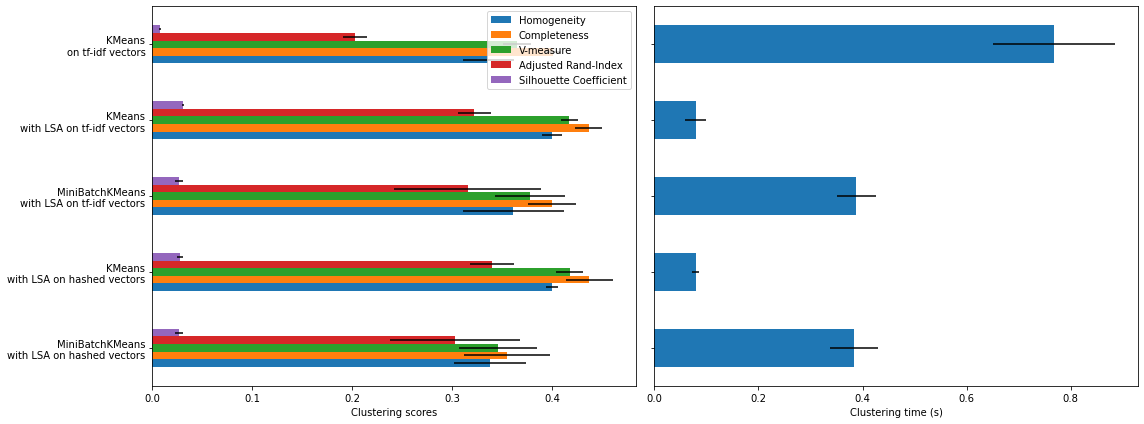

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(16, 6), sharey=True)

df = pd.DataFrame(evaluations[::-1]).set_index("estimator")
df_std = pd.DataFrame(evaluations_std[::-1]).set_index("estimator")

df.drop(
    ["train_time"],
    axis="columns",
).plot.barh(ax=ax0, xerr=df_std)
ax0.set_xlabel("Clustering scores")
ax0.set_ylabel("")

df["train_time"].plot.barh(ax=ax1, xerr=df_std["train_time"])
ax1.set_xlabel("Clustering time (s)")
plt.tight_layout()

[**`KMeans`**](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) et [**`MiniBatchKMeans`**](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html) souffrent du phénomène appelé le [**fléau de la dimensionnalité** (wkpd)](https://en.wikipedia.org/wiki/Curse_of_dimensionality) pour les ensembles de données de grande dimension tels que les données textuelles. C'est la raison pour laquelle les scores globaux s'améliorent lors de l'utilisation de LSA. L'utilisation de données réduites LSA améliore également la stabilité et nécessite un temps de clustering plus court, mais gardez à l'esprit que l'étape LSA elle-même prend beaucoup de temps, en particulier avec des vecteurs hachés.

Le coefficient de silhouette est défini entre 0 et 1. Dans tous les cas on obtient des valeurs proches de 0 (même si elles s'améliorent un peu après l'utilisation de LSA) car sa définition nécessite de mesurer des distances, contrairement à d'autres métriques d'évaluation comme la V-mesure et l'indice Rand ajusté qui est uniquement basé sur les affectations de grappes plutôt que sur les distances. Notez qu'à proprement parler, il ne faut pas comparer le coefficient de silhouette entre des espaces de dimension différente, en raison des différentes notions de distance qu'ils impliquent.

L'homogénéité, l'exhaustivité et donc les métriques de mesure v ne fournissent pas de référence en ce qui concerne l'étiquetage aléatoire : cela signifie qu'en fonction du nombre d'échantillons, de grappes et de classes de vérité terrain, un étiquetage complètement aléatoire ne donnera pas toujours les mêmes valeurs. En particulier, l'étiquetage aléatoire ne donnera pas de scores nuls, en particulier lorsque le nombre de clusters est important. Ce problème peut être ignoré en toute sécurité lorsque le nombre d'échantillons est supérieur à mille et le nombre de grappes est inférieur à 10, ce qui est le cas du présent exemple. Pour des tailles d'échantillon plus petites ou un plus grand nombre de grappes, il est plus sûr d'utiliser un indice ajusté tel que l'indice Rand ajusté (ARI). Voir l'exemple [**Ajustement pour le hasard dans l'évaluation des performances de clustering**](https://scikit-learn.org/stable/auto_examples/cluster/plot_adjusted_for_chance_measures.html) pour une démonstration sur l'effet de l'étiquetage aléatoire.

La taille des barres d'erreur montre que [**`MiniBatchKMeans`**](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html) est moins stable que [**`KMeans`**](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) pour cet ensemble de données relativement petit. Il est plus intéressant à utiliser lorsque le nombre d'échantillons est beaucoup plus important, mais cela peut se faire au prix d'une légère dégradation de la qualité du clustering par rapport à l'algorithme k-means traditionnel.